Check the appendix to look for filtering quotations and retrieval of stocks

# Load libraries and change path to your directory

In [78]:
import os
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import json
import bz2
import nltk

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
#Depending on your google drive update this
%cd "/content/drive/Othercomputers/Laptop/ADAFINAL/ada-2021-project-adaptiveness/"
!ls

/content/drive/Othercomputers/Laptop/ADAFINAL/ada-2021-project-adaptiveness
ada_project
Analysis.ipynb
baseline_w2v_china_trade_2018.json
china_trade_2018.json
china_trade_vader_pos_neg_sentiment.json
china_trade_vader_sentiment.json
china_trade_zero_shot_sentiment.json
china_trade_zero_shot_sent_pos_neg.json
data
data-story
LSTM_stock_pred.ipynb
quotes_extraction_basic_sentiment_analysis.ipynb
quotes_stocks_basic_analyses.ipynb
sentiment_china_trade_2018.json
sentiment_dictionary.csv
stock_data.ipynb
TradeWarUSAndChina.ipynb
US_China_Baseline.ipynb
US_China_Trade_War_Submission.ipynb
vader_sentiment.ipynb
zero_shot_sentiment.ipynb


# Methods to Assign sentiment to quotation

## Vader

In [76]:
def create_dataframe_from_json_bz2(path_file):
    with bz2.open(path_file, 'rb') as file:
        df = pd.read_json(file, lines=True)
    return df

In [79]:
years = ['2018', '2019', '2020']
data = [create_dataframe_from_json_bz2('ada_project/quotes-{}-china_trade.json.bz2'.format(year)) for year in years]
df = pd.concat(data, ignore_index=True)
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,[],2018-03-23 10:28:51,2,"[[None, 0.9112], [President Donald Trump, 0.08...",[http://www.breitbart.com/news/world-stock-mar...,E
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,[Q7176052],2018-04-08 04:00:00,17,"[[Peter Navarro, 0.6696], [None, 0.208], [LARR...",[http://dailylocal.com/general-news/20180408/a...,E
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,[Q15072639],2018-05-14 20:43:32,2,"[[Jonathan Fenby, 0.8834], [None, 0.1166]]",[https://www.fxstreet.com/news/wall-street-dow...,E
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,[Q54946635],2018-11-29 07:11:20,1,"[[A. Khan, 0.6289], [Narendra Modi, 0.204], [N...",[http://asia.nikkei.com/Politics/International...,E


In [80]:
df.drop(['qids', 'probas', 'urls', 'phase'], axis=1, inplace=True)
df.date = df.date.dt.strftime('%d/%m/%Y')
df.head()

,quoteID,quotation,speaker,date,numOccurrences
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,13/04/2018,1
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,23/03/2018,2
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,08/04/2018,17
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,14/05/2018,2
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,29/11/2018,1


In [ ]:
# Dont run cell, at least you wanted to compute the sentiment it will take a long time
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def compute_vader_sentiment(quotation):
    scores = analyzer.polarity_scores(quotation)
    if scores["neg"] > scores["pos"]:
        return -1
    return 1

df['vader_sentiment'] = df['quotation'].apply(lambda x: compute_vader_sentiment(x))
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,quoteID,quotation,speaker,date,numOccurrences,vader_sentiment
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,13/04/2018,1,1
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,23/03/2018,2,-1
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,08/04/2018,17,1
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,14/05/2018,2,1
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,29/11/2018,1,-1


In [ ]:
df.to_json('ada_project/china_trade_vader_sentiment.json', orient='records', lines=True)

## ONE SHOT BART MODEL

In [ ]:
!pip install transformers

In [ ]:
def create_dataframe_from_json_bz2(path_file):
    with bz2.open(path_file, 'rb') as file:
        df = pd.read_json(file, lines=True)
    return df

In [ ]:
years = ['2018']
data = [create_dataframe_from_json_bz2('ada_project/quotes-{}-china_trade.json.bz2'.format(year)) for year in years]
df = pd.concat(data, ignore_index=True)
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,[],2018-03-23 10:28:51,2,"[[None, 0.9112], [President Donald Trump, 0.08...",[http://www.breitbart.com/news/world-stock-mar...,E
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,[Q7176052],2018-04-08 04:00:00,17,"[[Peter Navarro, 0.6696], [None, 0.208], [LARR...",[http://dailylocal.com/general-news/20180408/a...,E
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,[Q15072639],2018-05-14 20:43:32,2,"[[Jonathan Fenby, 0.8834], [None, 0.1166]]",[https://www.fxstreet.com/news/wall-street-dow...,E
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,[Q54946635],2018-11-29 07:11:20,1,"[[A. Khan, 0.6289], [Narendra Modi, 0.204], [N...",[http://asia.nikkei.com/Politics/International...,E


In [ ]:
df.drop(['qids', 'probas', 'urls', 'phase'], axis=1, inplace=True)
df.date = df.date.dt.strftime('%d/%m/%Y')
df.head()

,quoteID,quotation,speaker,date,numOccurrences
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,13/04/2018,1
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,23/03/2018,2
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,08/04/2018,17
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,14/05/2018,2
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,29/11/2018,1


In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification")

hypothesis_template = 'The sentiment of this quote is {}.'
# labels = ['positive', 'negative']
labels = ['calm', 'alert', 'sure', 'vital', 'kind', 'happy']

sentiment = []

sequences = df['quotation'].to_numpy()
for quotation in tqdm(sequences):
    pred = classifier(quotation, labels, hypothesis_template=hypothesis_template, multi_label=True)  # Set multi_label=True
    sentiment.append(pred)

# 36 591 quotes to process

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)
 88%|████████▊ | 14404/16392 [11:10:03<1:14:39,  2.25s/it]

In [ ]:
with open('ada_project/china_trade_zero_shot_sent_extra_features.json', 'w') as file:  # Set yout own path
    json.dump(sentiment, file)

# Analisis of extracted quotations with sentiment features

Here we are loading the quotes dataset with sentiment features computed with zero shot classification bart model. At first when using this model we  computed those sentiment features in a binary way. We will discuss this choice later and why we moved on probabilities of sentiment instead.

In [11]:
quotes = pd.read_json('china_trade_zero_shot_sentiment.json', orient='records', lines=True)
stock = pd.read_csv('data/stock_data/BG_data.csv')

Since we created string features for bart sentiment analysis we convert it to (-1,1) labels for better interpretability.

In [12]:
quotes.bart_sentiment = quotes.bart_sentiment.apply(lambda x: 1.0 if x == 'positive' else - 1.0)
quotes.head()

,quoteID,quotation,speaker,date,numOccurrences,bart_sentiment
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,2018-04-13,1,1.0
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,2018-03-23,2,-1.0
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,2018-08-04,17,-1.0
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,2018-05-14,2,-1.0
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,2018-11-29,1,1.0


We compute the number of quotations we have extracted that covered the whole trade war period along with the number of "unique" speakers (actually different speaker names refer to the same person, e.g. Donald Trump).

In [13]:
if len(np.unique(quotes.quotation)) == len(quotes):
    print('There are {} unique quotations.'.format(len(quotes)))
print('There are {} unique predicted speakers.'.format(len(np.unique(quotes.speaker))))

There are 36591 unique quotations.
There are 7244 unique predicted speakers.


To get a sense of most representative speakers for the extracted quotes, we removed the not attributed speaker "None" and we selected the top 20 speakers according to quotations counts. Then we build a pie chart amoung those 20 speakers.

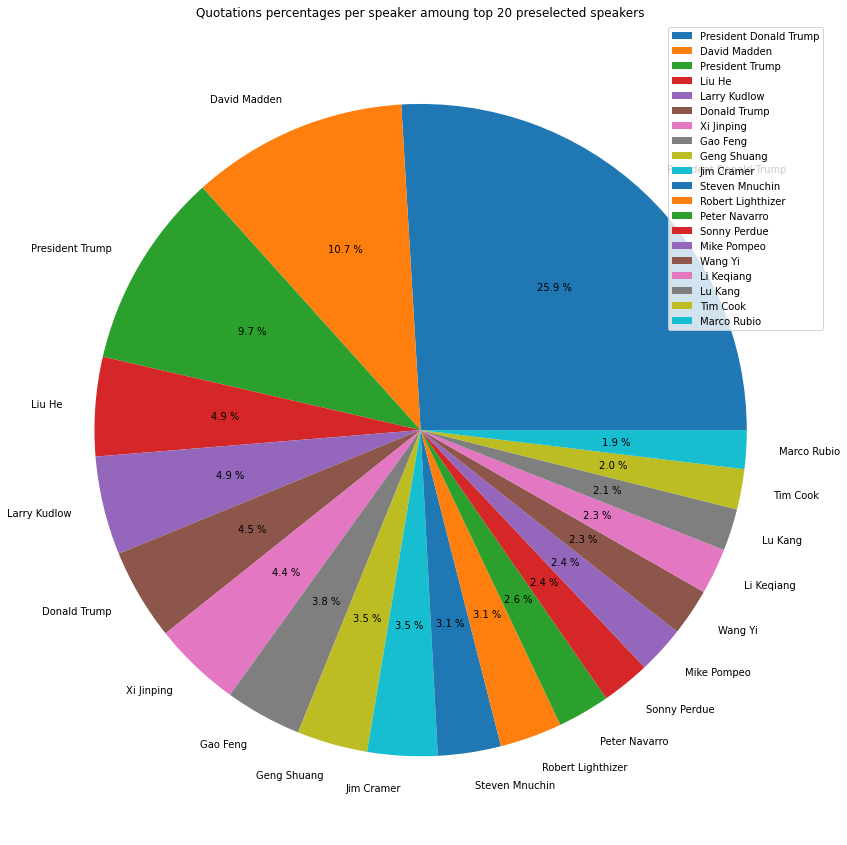

In [14]:
top_20_speakers = quotes[quotes.speaker != 'None'].speaker.value_counts().nlargest(n=20)
top_20_speakers = top_20_speakers / len(top_20_speakers)
top_20_speakers.plot.pie(autopct='%.1f %%', ylabel='', legend=True, figsize=(15, 15))
plt.title('Quotations percentages per speaker amoung top 20 preselected speakers')
plt.show()

We can also create a wordcloud from the extracted quotes to confirm that our quote extraction was successful.

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt	
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(col):
	"""
	Takes in dataframe and plots a wordclous using matplotlib
	"""
	plt.subplots(figsize = (12,10))
	wordcloud = WordCloud(
							background_color = 'white',
							width = 1000,
							height = 800).generate(" ".join(col))
	plt.imshow(wordcloud)
	plt.axis('off')
	plt.show()

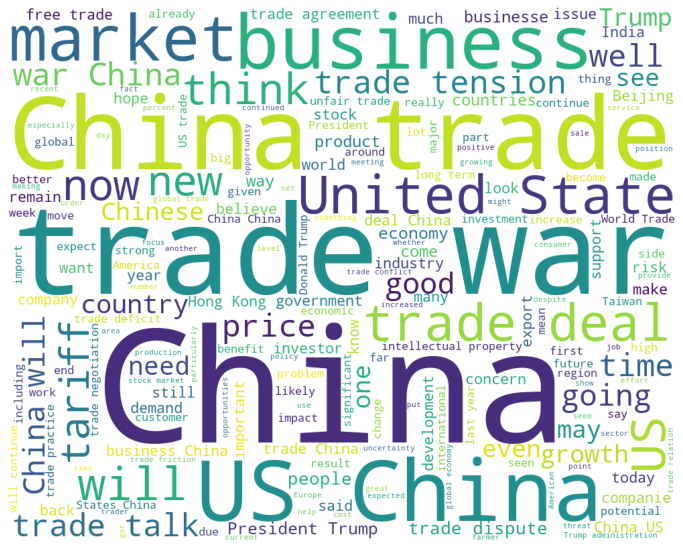

In [17]:
word_cloud(quotes['quotation'])

We are interested into news sentiment per day so we can average the sentiment for the quotes collected in each corresponding day.

In [18]:
sent_per_day = quotes[['date', 'bart_sentiment']].groupby(['date']).mean()
sent_per_day

,bart_sentiment
date,
2018-01-01,-0.250000
2018-01-02,0.590909
2018-01-03,-0.291667
2018-01-04,-0.076923
2018-01-05,0.128205
...,...
2020-11-04,-1.000000
2020-12-01,0.304348
2020-12-02,-0.550000


We can now visualize the sentiment time seris for the whole trade war period.

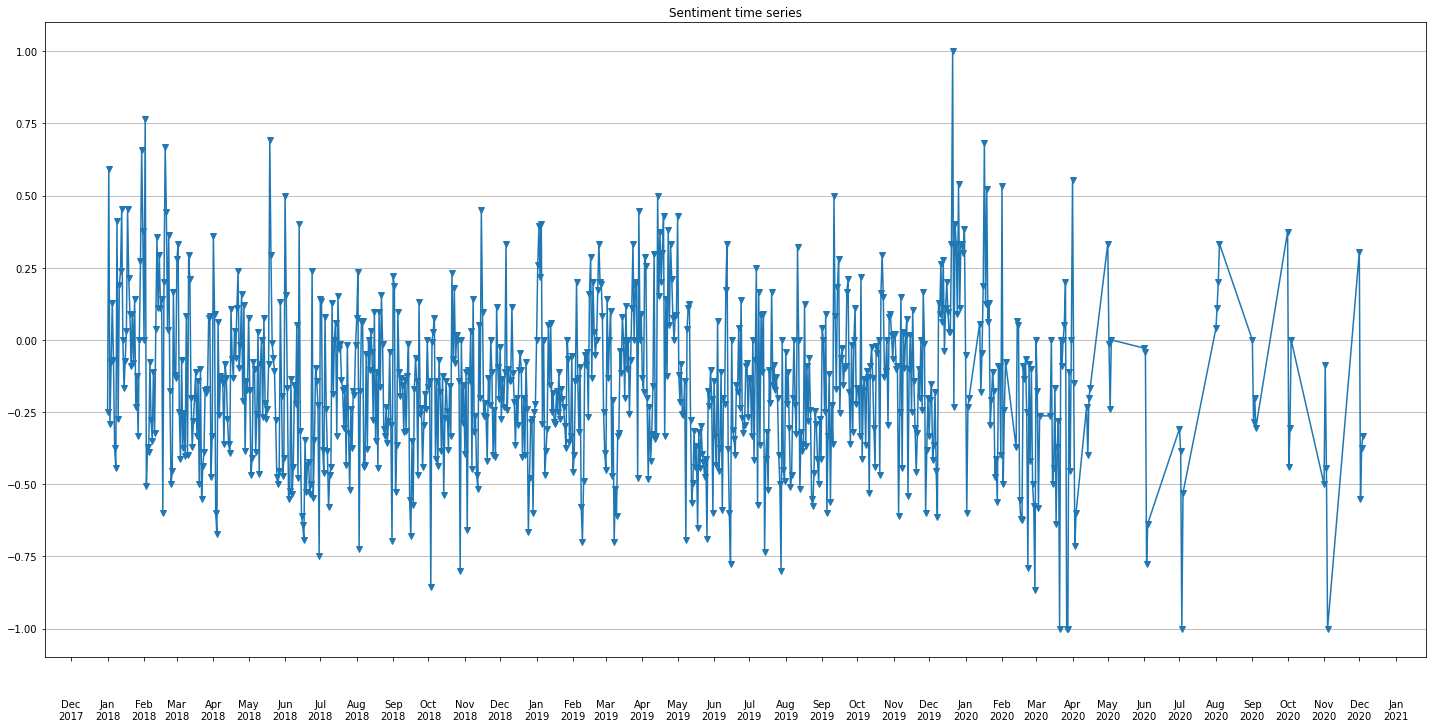

In [19]:
import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(sent_per_day.index.to_pydatetime(), sent_per_day.bart_sentiment, 'v-')
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.title('Sentiment time series')
plt.show()

As we stated in the quotes extraction process, we kept numOccurences Quotebank's feature to perform extra weighting for frequently occuring quotes? Hence we can plot the previous time series after weighting daily sentiment accordingly.

In [20]:
quotes['weighted_sent'] = quotes.bart_sentiment * quotes.numOccurrences
quotes.head()

,quoteID,quotation,speaker,date,numOccurrences,bart_sentiment,weighted_sent
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,2018-04-13,1,1.0,1.0
1,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,2018-03-23,2,-1.0,-2.0
2,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,2018-08-04,17,-1.0,-17.0
3,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,2018-05-14,2,-1.0,-2.0
4,2018-11-29-030995,"he would be able to strike a chord with Xi, wh...",A. Khan,2018-11-29,1,1.0,1.0


In [21]:
weighted_sent_per_day = quotes[['date', 'weighted_sent']].groupby(['date']).sum()
weighted_sent_per_day

,weighted_sent
date,
2018-01-01,-75.0
2018-01-02,366.0
2018-01-03,-12.0
2018-01-04,-318.0
2018-01-05,-44.0
...,...
2020-11-04,-56.0
2020-12-01,20.0
2020-12-02,-74.0


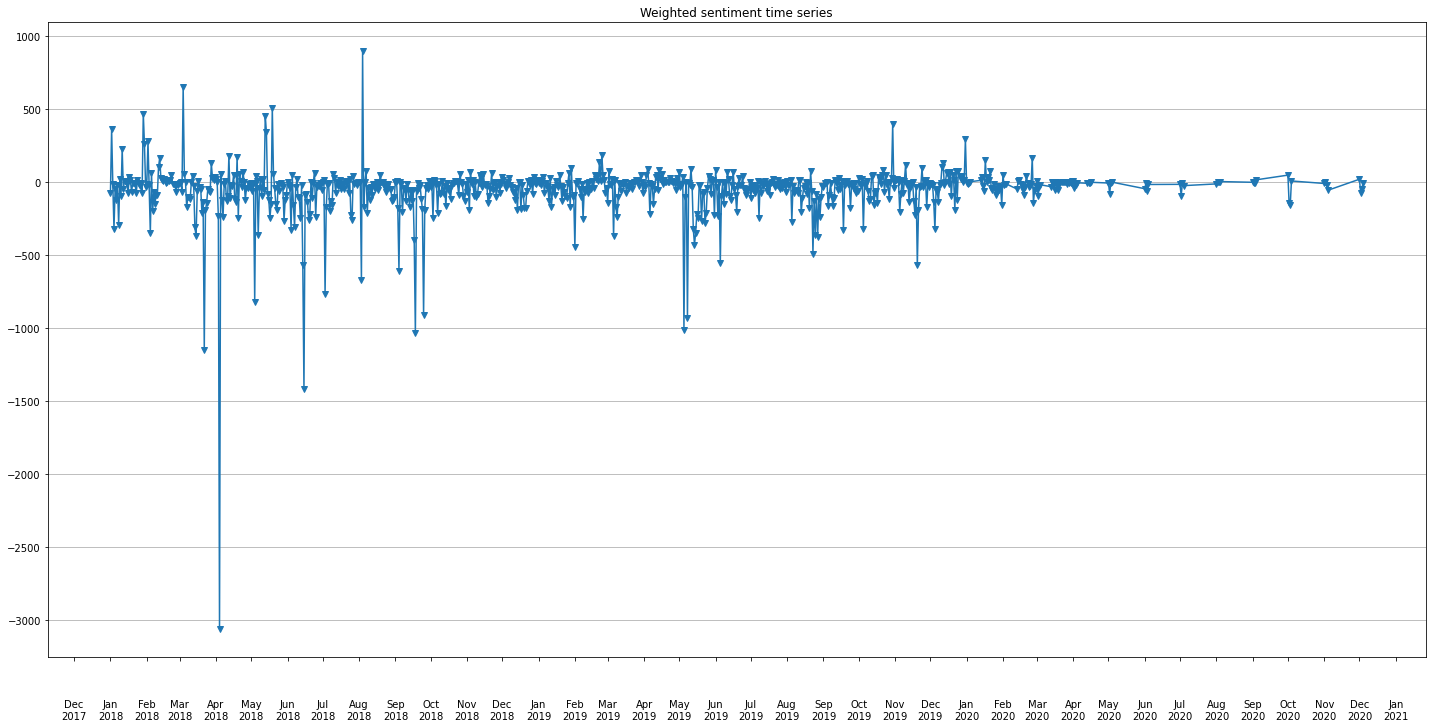

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(weighted_sent_per_day.index.to_pydatetime(), weighted_sent_per_day.weighted_sent, 'v-')
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.title('Weighted sentiment time series')
plt.show()

We can now move on basic stock analyses.

In [23]:
stock.head()

,Date,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
0,2018-01-02,58.842545,59.542735,58.159851,59.507725,944500,NaN,NaN
1,2018-01-03,59.849074,61.450770,59.568997,60.785583,2124600,0.021247,1.0
2,2018-01-04,61.074403,62.325999,61.048146,61.678322,2026900,0.014580,1.0
3,2018-01-05,61.704588,62.133455,60.873111,61.214455,795500,-0.007549,-1.0
4,2018-01-08,61.048154,61.065656,59.726536,60.330456,1041200,-0.014546,-1.0


We computed log returns from yahoo finance daily data which happens to be not defined in some cases. To fill the nan values we applied the bfill method (filling with next valid value, i.e. next valid daily value).

In [24]:
stock[stock.Log_return_onehot.isnull()]

,Date,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
0,2018-01-02,58.842545,59.542735,58.159851,59.507725,944500,NaN,NaN


In [25]:
stock.fillna(method='bfill', inplace=True)

We can now plot the log returns time series xhich is a strong indicator of the stock market variations.

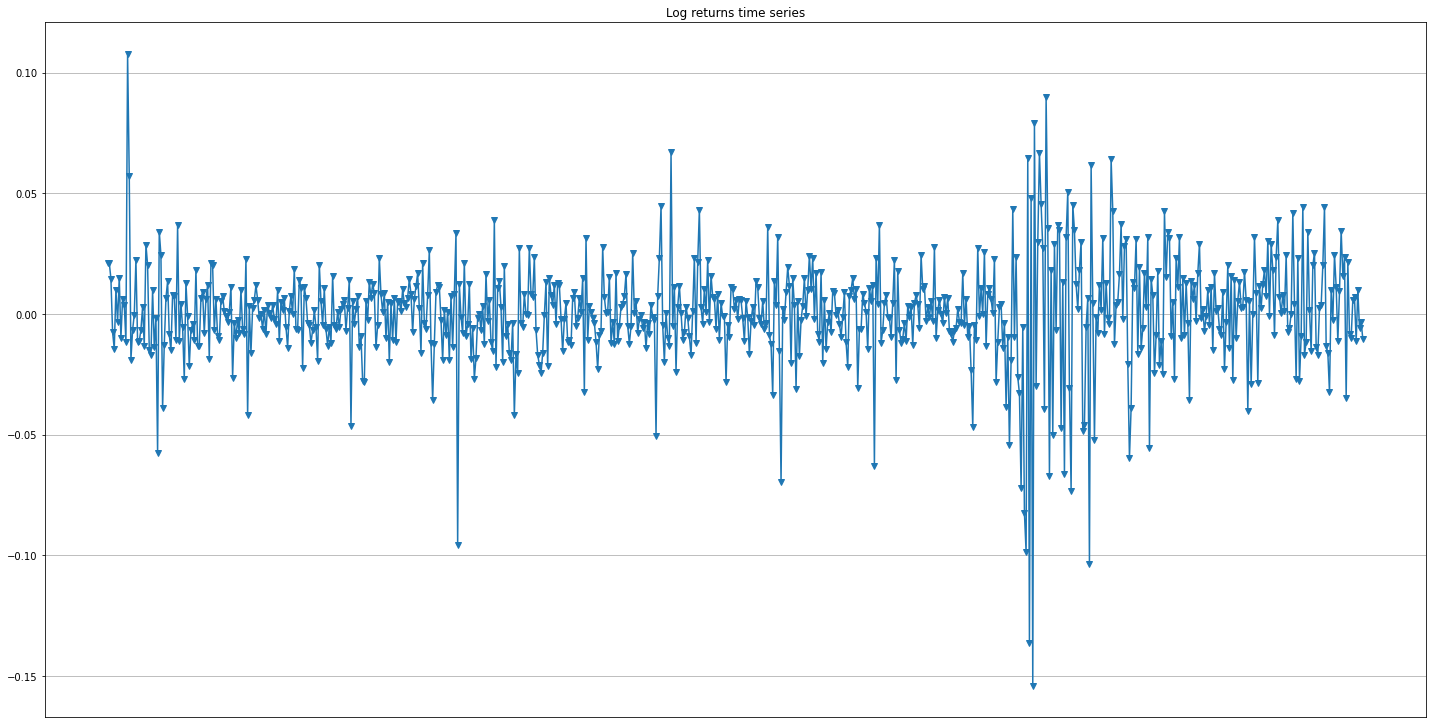

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(stock.Date, stock.Log_returns, 'v-')
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.title('Log returns time series')
plt.show()

Now it is time to build some dataset incorporating quotes sentiment and stock variations to start investigate.

In [27]:
data = sent_per_day.join(stock.set_index('Date'))[['bart_sentiment', 'Log_return_onehot']]
data.fillna(method='bfill', inplace=True)
data = data.join(weighted_sent_per_day)
data.rename({'bart_sentiment': 'avg_sent', 'Log_return_onehot': 'stock_var'}, axis=1, inplace=True)
data.head()

,avg_sent,stock_var,weighted_sent
date,,,
2018-01-01,-0.250000,1.0,-75.0
2018-01-02,0.590909,1.0,366.0
2018-01-03,-0.291667,1.0,-12.0
2018-01-04,-0.076923,1.0,-318.0
2018-01-05,0.128205,-1.0,-44.0


For the average sentiment we can compute a binary encoding value to match the stock variation encoding.

In [28]:
data['sent'] = data.avg_sent.apply(lambda x: 1.0 if x >= 0.0 else -1.0)
data.head()

,avg_sent,stock_var,weighted_sent,sent
date,,,,
2018-01-01,-0.250000,1.0,-75.0,-1.0
2018-01-02,0.590909,1.0,366.0,1.0
2018-01-03,-0.291667,1.0,-12.0,-1.0
2018-01-04,-0.076923,1.0,-318.0,-1.0
2018-01-05,0.128205,-1.0,-44.0,1.0


Now that everything is set up we can start investigate the relation between sentiment amoung quotes and stock variations. Let's build a basic classifier.

In [29]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
mod = smf.ols(formula='stock_var ~ avg_sent', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              stock_var   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5925
Date:                Fri, 17 Dec 2021   Prob (F-statistic):              0.442
Time:                        20:35:58   Log-Likelihood:                -1187.3
No. Observations:                 837   AIC:                             2379.
Df Residuals:                     835   BIC:                             2388.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0042      0.040      0.105      0.9

We can see that the R2 coefficient is very low, daily quotes' average sentiment does not explain daily stock variation variance very well. Moreover we can see that avg_sent is a non significant predicor judging by the p-value. Maybe we can improve the results using binary encoded sentiment or weighted daily sentiment with numOccurences feature.

In [31]:
mod = smf.ols(formula='stock_var ~ sent', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              stock_var   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01605
Date:                Fri, 17 Dec 2021   Prob (F-statistic):              0.899
Time:                        20:36:00   Log-Likelihood:                -1187.6
No. Observations:                 837   AIC:                             2379.
Df Residuals:                     835   BIC:                             2389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0088      0.038     -0.233      0.8

In [32]:
mod = smf.ols(formula='stock_var ~ weighted_sent', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              stock_var   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2235
Date:                Fri, 17 Dec 2021   Prob (F-statistic):              0.637
Time:                        20:36:03   Log-Likelihood:                -1187.5
No. Observations:                 837   AIC:                             2379.
Df Residuals:                     835   BIC:                             2388.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0060      0.036     -0.165

We can see that these features are even worst predictors and the R2 square is lower. We can wonder what is the proportion of days when the computed binary average quote sentiment matches the corresponding day binary encoded stock variation:

In [33]:
len(data[data.sent == data.stock_var]) / len(data)

0.5041816009557945

In only 50% of the cases the binary sentiment and binary stock variation are matching. Using this kind of approach is basically link tossing a coin to predict the stock variation... We might want to include memory in our features, quotes and stocks may be non correlated or at least not in a instant daily fashion.

To investigate a bit more we can focus on a shorter time period within the trade war and compare the quotes sentiment and stock variations.

In [34]:
import datetime as dt
start = data.index.searchsorted(dt.datetime(2018, 1, 1))
end = data.index.searchsorted(dt.datetime(2018, 2, 1))
zoom = data.iloc[start:end]

As we said before, we have some intuition that some kind of memory would be necessary to get better correlation between stocks variations and quotes sentiment. For that, we will average the quotes sentiment over a 3 days time window i.e. to compute the quotes sentiment at time t, we include quotes sentiment of days t-2, t-1 and t.

In [35]:
zoom['avg_sent_3_days'] = zoom.avg_sent.rolling(window=3,min_periods=0).mean()
zoom.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,avg_sent,stock_var,weighted_sent,sent,avg_sent_3_days
date,,,,,
2018-01-01,-0.250000,1.0,-75.0,-1.0,-0.250000
2018-01-02,0.590909,1.0,366.0,1.0,0.170455
2018-01-03,-0.291667,1.0,-12.0,-1.0,0.016414
2018-01-04,-0.076923,1.0,-318.0,-1.0,0.074106
2018-01-05,0.128205,-1.0,-44.0,1.0,-0.080128


We first plot stocks and quotes sentiments variations to confirm that their variations are not correlated in a daily basis.

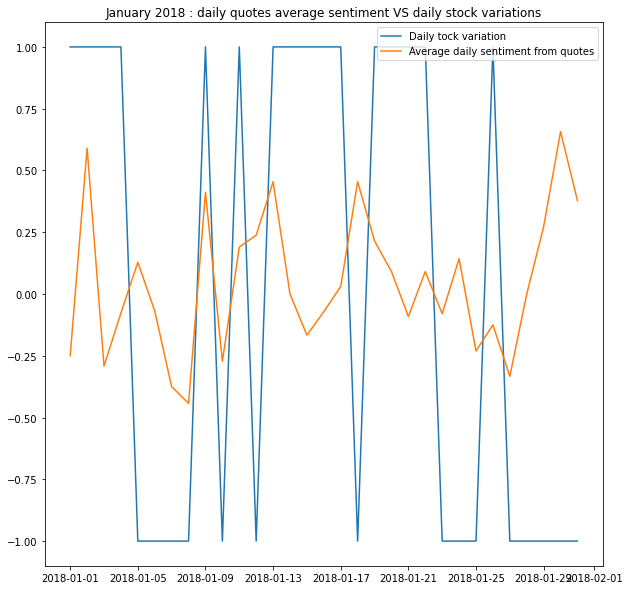

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(zoom.index, zoom.stock_var, label='Daily tock variation')
plt.plot(zoom.index, zoom.avg_sent, label='Average daily sentiment from quotes')
plt.title("January 2018 : daily quotes average sentiment VS daily stock variations")
plt.legend(loc='upper right')
plt.show()

Since the plot is not really readable, we also computed pearson correlation. The correlation is very weak at 0.03 and the p-value roughly indicates a 0.87 probability that an uncorrelated system produced datasets with such a Pearson correlation.

In [37]:
from scipy import stats
stats.pearsonr(zoom.stock_var, zoom.sent)

(0.029288959306450313, 0.8757130654239328)

Let's see if we can have a better correlation when using soem memory.

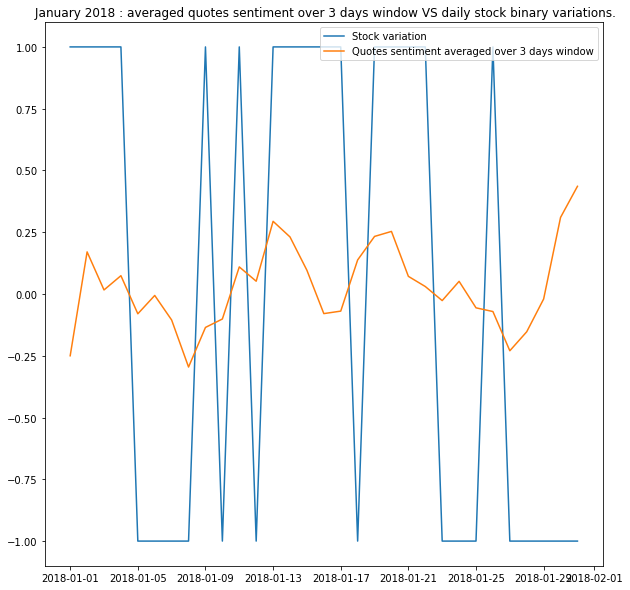

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(zoom.index, zoom.stock_var, label='Stock variation')
plt.plot(zoom.index, zoom.avg_sent_3_days, label='Quotes sentiment averaged over 3 days window')
plt.title(" January 2018 : averaged quotes sentiment over 3 days window VS daily stock binary variations.")
plt.legend(loc='upper right')
plt.show()

We can see that while not perfect, the average operation over past few days really improved the visuals, we can see that variations in quotes sentiment roughly matches the stock variations, often with some delay. We can compute the correlation improvement in that scenario to assess the relevance of the memory operation. The correlation is almost 10 times higher and the p-value significantly dropped. With this rough investigation we now want to dive into this approach to hope for stock prediction using quotes sentiment.

In [39]:
from scipy import stats
stats.pearsonr(zoom.stock_var, zoom.avg_sent_3_days)

(0.1958821469798473, 0.2909312243302414)

We can also see using a binary encoder that stock variations and quotes sentiment variations on a daily basis match more often (now 67% of the time when using memory.

In [40]:
len(zoom[zoom.sent == zoom.stock_var]) / len(zoom)

0.5161290322580645

In [43]:
zoom['avg_sent_3_days_norm'] = zoom.avg_sent_3_days.apply(lambda x: x/np.abs(x) if x != 0.0 else 1.0)
len(zoom[zoom.avg_sent_3_days_norm == zoom.stock_var]) / len(zoom)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.6774193548387096

# Predicting Stocks

But now our big question is how well the sentiment of quotes will helps us to predict the stock market, Our first naive approach was to create classifier with famous models for binary classification, for this classification we are taking into account that the log return colum is encoded with discrete -1,1 values where -1 represent a negative return and 1 represent a positive return

In [45]:
data.head()

,avg_sent,stock_var,weighted_sent,sent
date,,,,
2018-01-01,-0.250000,1.0,-75.0,-1.0
2018-01-02,0.590909,1.0,366.0,1.0
2018-01-03,-0.291667,1.0,-12.0,-1.0
2018-01-04,-0.076923,1.0,-318.0,-1.0
2018-01-05,0.128205,-1.0,-44.0,1.0


In [46]:
train_in = data.copy()
features_names = ["avg_sent","weighted_sent", "avg_sent_3_days"]
train_in['avg_sent_3_days'] = train_in.avg_sent.rolling(window=3,min_periods=0).mean()

In [53]:
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
clf = GradientBoostingClassifier()
print("GradientBoostingClassifier")
# Execute cross validation of k4
scores = cross_val_score(clf, train_in[features_names], train_in[['stock_var']].values.ravel(), cv=4)
print("the scores of the cross validation are " + str(scores))
print("the average f1 score of this classifier is: " + str(scores.mean()))

GradientBoostingClassifier
the scores of the cross validation are [0.53333333 0.57416268 0.49282297 0.52631579]
the average f1 score of this classifier is: 0.5316586921850079


In [54]:
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
clf = SGDClassifier(max_iter=1000, tol=1e-3)
scores = cross_val_score(clf, train_in[features_names], train_in[['stock_var']].values.ravel(), cv=4)
print("SGDClassifier")
print("the scores of the cross validation are " + str(scores))
print("the average f1 score of this classifier is: " + str(scores.mean()))

SGDClassifier
the scores of the cross validation are [0.5047619  0.50717703 0.55502392 0.58373206]
the average f1 score of this classifier is: 0.537673729778993


In [56]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=200, random_state=0)
scores = cross_val_score(clf, train_in[features_names], train_in[['stock_var']].values.ravel(), cv=4)
print("RandomForestClassifier")
print("the scores of the cross validation are " + str(scores))
print("the average f1 score of this classifier is: " + str(scores.mean()))

the scores of the cross validation are [0.4952381  0.55023923 0.48325359 0.42583732]
the average f1 score of this classifier is: 0.4886420596946913


In [57]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC()
scores = cross_val_score(clf, train_in[features_names], train_in[['stock_var']].values.ravel(), cv=4)
print("SVC")
print("the scores of the cross validation are " + str(scores))
print("the average f1 score of this classifier is: " + str(scores.mean()))

SVC
the scores of the cross validation are [0.4952381  0.48325359 0.49760766 0.47368421]
the average f1 score of this classifier is: 0.4874458874458874


these result that common classifiers are not suitable for this prediction, that is why we decided to move with neural networks that are very well stated in state of arts papers to forecast stocks

In [59]:
import matplotlib.pyplot as plt
stocks = ['BG', 'CSX', 'GM', 'NVDA', 'CAT', 'DE', 'HOG', 'SWKS']
stock_name = 'BG'
quotes = pd.read_json('china_trade_vader_pos_neg_sentiment.json', orient='records', lines=True)
stock = pd.read_csv('data/stock_data/{}_data.csv'.format(stock_name))

We average the sentiment probabilities by day to be able to join with the daily stock data.

In [60]:
quotes_per_day = quotes[['date', 'vader_pos', 'vader_neg']].groupby(['date']).mean()
quotes_per_day.head()

,vader_pos,vader_neg
date,,
2018-01-01,0.061125,0.078625
2018-01-02,0.143818,0.030705
2018-01-03,0.087583,0.091646
2018-01-04,0.133154,0.089462
2018-01-05,0.112897,0.061077


In [61]:
data = quotes_per_day.join(stock.set_index('Date'))
data.head()

,vader_pos,vader_neg,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
date,,,,,,,,,
2018-01-01,0.061125,0.078625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.143818,0.030705,58.842545,59.542735,58.159851,59.507725,944500.0,NaN,NaN
2018-01-03,0.087583,0.091646,59.849074,61.450770,59.568997,60.785583,2124600.0,0.021247,1.0
2018-01-04,0.133154,0.089462,61.074403,62.325999,61.048146,61.678322,2026900.0,0.014580,1.0
2018-01-05,0.112897,0.061077,61.704588,62.133455,60.873111,61.214455,795500.0,-0.007549,-1.0


In [62]:
data.drop('Log_return_onehot', axis=1, inplace=True)
data.head()

,vader_pos,vader_neg,Open,High,Low,Close,Volume,Log_returns
date,,,,,,,,
2018-01-01,0.061125,0.078625,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.143818,0.030705,58.842545,59.542735,58.159851,59.507725,944500.0,NaN
2018-01-03,0.087583,0.091646,59.849074,61.450770,59.568997,60.785583,2124600.0,0.021247
2018-01-04,0.133154,0.089462,61.074403,62.325999,61.048146,61.678322,2026900.0,0.014580
2018-01-05,0.112897,0.061077,61.704588,62.133455,60.873111,61.214455,795500.0,-0.007549


In [63]:
data = data.reindex(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Log_returns', 'vader_pos', 'vader_neg'])  # Switch the order of features to make easier removal of sentiment features
data.head()

,Open,High,Low,Close,Volume,Log_returns,vader_pos,vader_neg
date,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.061125,0.078625
2018-01-02,58.842545,59.542735,58.159851,59.507725,944500.0,NaN,0.143818,0.030705
2018-01-03,59.849074,61.450770,59.568997,60.785583,2124600.0,0.021247,0.087583,0.091646
2018-01-04,61.074403,62.325999,61.048146,61.678322,2026900.0,0.014580,0.133154,0.089462
2018-01-05,61.704588,62.133455,60.873111,61.214455,795500.0,-0.007549,0.112897,0.061077


Some dates are in the quotes data but not in the stock data or some features like log return are not define in some cases. We decide to fill nan values with bfill method.

In [64]:
np.sum(data.isnull())

Open           259
High           259
Low            259
Close          259
Volume         259
Log_returns    260
vader_pos        0
vader_neg        0
dtype: int64

In [65]:
data.fillna(method='bfill', inplace=True)
np.sum(data.isnull())

Open           0
High           0
Low            0
Close          0
Volume         0
Log_returns    0
vader_pos      0
vader_neg      0
dtype: int64

We define the hyperparameters for the LSTM algorithm, timesteps are the previous days to take into account when forecasting. We can decide to include or not sentiment features to assess sentiment analysis improvement.

In [66]:
max_timesteps = len(data)
timesteps = 20
assert timesteps <= max_timesteps, 'Wrong timesteps value'
epochNum = 200
include_sentiment_features = True

We scale the features before training within the range (0,1) and split the data without shuffle since we need to keep time order for forecasting.

In [67]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))  # Scaling the features

split_idx = int(0.9 * len(data))  # 90:10 train:test split, we must keep time order so no sklearn train_test_split

if include_sentiment_features:
    train, test = data.values[:split_idx], data.values[split_idx:]
else:
    train, test = data.values[:split_idx, :6], data.values[split_idx:, :6]

train_time, test_time = data.index.values[timesteps:split_idx], data.index.values[split_idx + timesteps:]

y_train_raw = data.values[timesteps:split_idx, 0]  # We select Open value as true stock value for a given time step
y_true = data.values[split_idx + timesteps:, 0]

train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(timesteps, len(train)):
    X_train.append(train[i-timesteps:i])    
    y_train.append(train[i, 0])  # We select Open value as true stock value for a given time step                
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))  # Shape (#samples, #timesteps, #features)

In [68]:
X_test = []

test_scaled = sc.transform(test)

for i in range(timesteps, len(test)):
  X_test.append(test_scaled[i-timesteps:i])
X_test, y_true = np.array(X_test), np.array(y_true)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))  # Shape (#samples, #timesteps, #features)

We build our simple LSTM model to predict Open stock value at timestep t+1.

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

regressor = Sequential()
regressor.add(LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
regressor.add(LSTM(units=16))
regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.summary()


regressor.fit(X_train, y_train, batch_size=32, epochs=epochNum)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            5248      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
23/23 [==============================] - 4s 15ms/step - loss: 0.0688
Epoch 2/200
23/23 [==============================] - 0s 14ms/step - loss: 0.0069
Epoch 3/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0032
Epoch 4/200
23/23 [==============================] - 0s 17ms/step - loss: 0

We can now predict the stock variations for the remaining timelapse in test set. We use some padding to scale back the Open stock feature.

In [70]:
y_pred = np.zeros((y_true.shape[0], X_test.shape[2]))
y_pred[:, 0] = np.squeeze(regressor.predict(X_test))  # Padding to scale back
y_pred = sc.inverse_transform(y_pred)
y_pred = np.delete(y_pred, np.arange(1, X_test.shape[2]), axis=1)

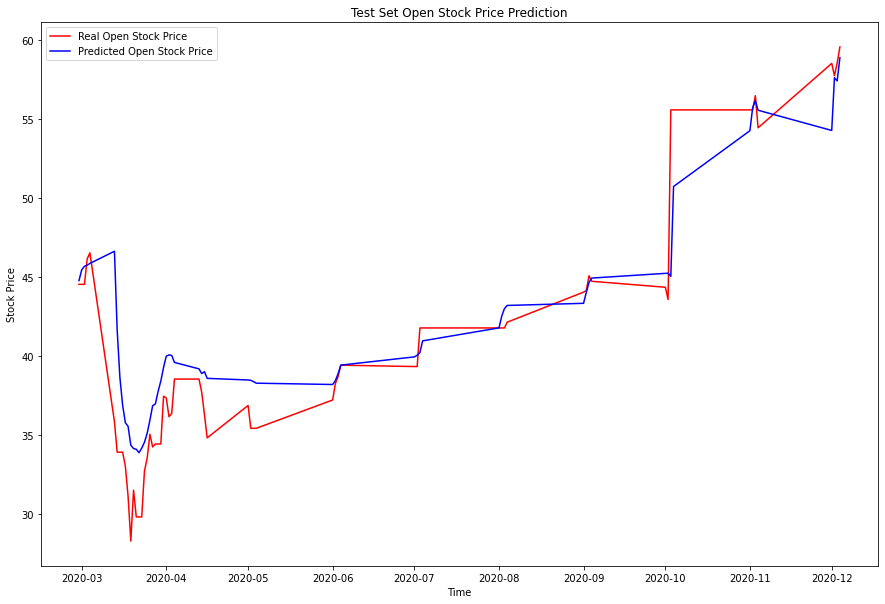

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(test_time, y_true, color='red', label='Real Open Stock Price')
plt.plot(test_time, y_pred, color='blue', label='Predicted Open Stock Price')
plt.title('Test Set Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
# plt.savefig(''.format())

In [72]:
y_train_pred = np.zeros((y_train_raw.shape[0], X_train.shape[2]))
y_train_pred[:, 0] = np.squeeze(regressor.predict(X_train))  # Padding to scale back
y_train_pred = sc.inverse_transform(y_train_pred)
y_train_pred = np.delete(y_train_pred, np.arange(1, X_train.shape[2]), axis=1)

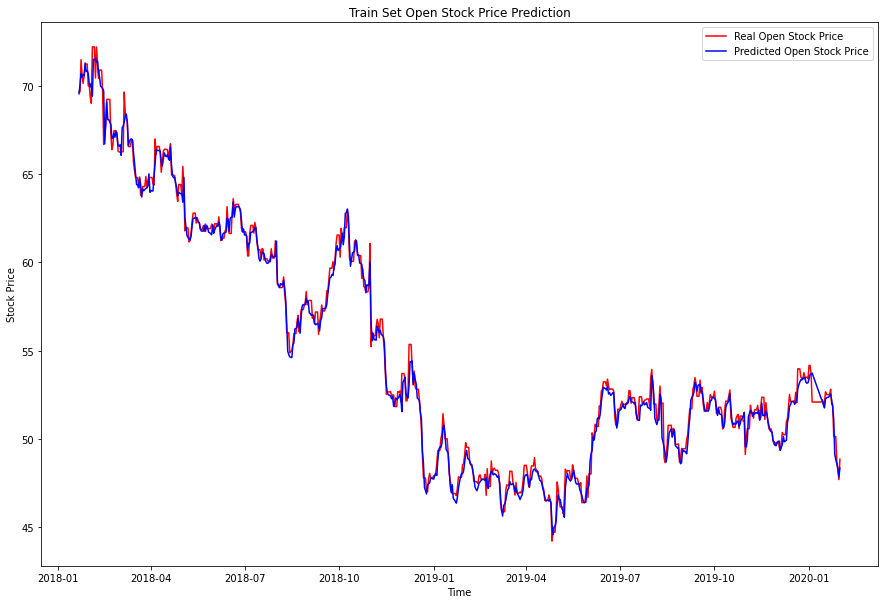

In [73]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(train_time, y_train_raw, color='red', label='Real Open Stock Price')
plt.plot(train_time, y_train_pred, color='blue', label='Predicted Open Stock Price')
plt.title('Train Set Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
# plt.savefig(''.format())

In [74]:
import math
from sklearn.metrics import mean_squared_error

rmse_test = math.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE_test = {}".format(rmse_test))
rmse_train = math.sqrt(mean_squared_error(y_train_raw, y_train_pred))
print("RMSE_train = {}".format(rmse_train))

RMSE_test = 3.168661729140737
RMSE_train = 0.5080534050409913


In [75]:
# BG stock with Vader sentiment

RMSE_test = 2.8048925751249034
RMSE_train = 0.5117984277785409
RMSE_test_no_sent = 2.5577450168172526
RMSE_train_no_sent = 0.5248834522340264

RMSE_test_improvement = (RMSE_test_no_sent - RMSE_test) / RMSE_test
RMSE_train_improvement = (RMSE_train_no_sent - RMSE_train) / RMSE_train

print('RMSE_test_improvement = {} %'.format(RMSE_test_improvement * 100))
print('RMSE_train_improvement = {} %'.format(RMSE_train_improvement * 100))

RMSE_test_improvement = -8.811302097608682 %
RMSE_train_improvement = 2.5566753911849704 %


# Appendix

## Quotes collection

Milestone2

In [ ]:
def extract_quotes_with_words(path_input_file, path_output_file, target_words):
    with bz2.open(path_input_file, 'rb') as input_file:
        with bz2.open(path_output_file, 'wb') as output_file:
            for instance in input_file:
                instance = json.loads(instance)
                quote = instance['quotation']
                for word in target_words:
                    if word in quote.lower():
                        output_file.write((json.dumps(instance)+'\n').encode('utf-8'))
                        break  #allow us to avoid duplicates if a quote countains several target_words
    return None

In [ ]:
extract_quotes_with_words('/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2', '/content/quotes-2018-china.json.bz2', target_words)

Then, among "china" related quotes, we extract quotes dealing specificly with trade topics. The corresponding file will be available in the repository.

In [ ]:
extract_quotes_with_words('/content/quotes-2018-china.json.bz2', '/content/quotes-2018-china_trade.json.bz2', trade_words)

In [ ]:
path_china_2018 = '/content/quotes-2018-china.json.bz2' 
path_china_trade_2018 = '/content/quotes-2018-china_trade.json.bz2'

This function allows us to compute the number of quotes extracted in the new archive file without laoding all the data.

In [ ]:
def count_quotes(path_file):
    instances = 0
    with bz2.open(path_file, 'rb') as file:
        for instance in file:
            instances += 1
    return instances

count_quotes(path_china_trade_2018)

Now that the number of quotes has been significantly reduced, we can laod it into a dataframe to perform analysis.

In [ ]:
def create_dataframe_from_json_bz2(path_file):
    with bz2.open(path_file, 'rb') as file:
        df = pd.read_json(file, lines=True)
    return df

In [ ]:
china_trade_2018 = create_dataframe_from_json_bz2(path_china_trade_2018)

In [ ]:
china_trade_2018.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E
1,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E
2,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,[],2018-03-23 10:28:51,2,"[[None, 0.9112], [President Donald Trump, 0.08...",[http://www.breitbart.com/news/world-stock-mar...,E
3,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,[Q7176052],2018-04-08 04:00:00,17,"[[Peter Navarro, 0.6696], [None, 0.208], [LARR...",[http://dailylocal.com/general-news/20180408/a...,E
4,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,[Q15072639],2018-05-14 20:43:32,2,"[[Jonathan Fenby, 0.8834], [None, 0.1166]]",[https://www.fxstreet.com/news/wall-street-dow...,E


In [ ]:
len(china_trade_2018)

18020

We will now create some basics feature using NLP python librairies to demonstrate the feasibility of our project. TextBlob and vaderSentiment are using a rule-based approach, meaning that they aggregate the sentiment of each word in a sentence to give the sentence a polarity.

In [ ]:
from textblob import TextBlob

testimonial = TextBlob("The food was great!")
print(testimonial.sentiment)

Sentiment(polarity=1.0, subjectivity=0.75)


In [ ]:
def create_textblob_features(df):
    df['textblob_polarity'] = df.quotation.apply(lambda quote: TextBlob(quote).sentiment[0])
    df['textblob_subjectivity'] = df.quotation.apply(lambda quote: TextBlob(quote).sentiment[1])
    return None

create_textblob_features(china_trade_2018)

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 16.3 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


analyzer = SentimentIntensityAnalyzer()
sentence = "The food was great!" 
vs = analyzer.polarity_scores(sentence)
print(vs)

{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}


In [ ]:
def create_vader_features(df):
    analyzer = SentimentIntensityAnalyzer()
    df['vader_compound'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['compound'])
    df['vader_neg'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['neg'])
    df['vader_pos'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['pos'])
    df['vader_neu'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['neu'])
    return None

create_vader_features(china_trade_2018)

Flair library is using a different approach for sentiment analysis, using embeddings to capture the context of the sentence before computing the sentence label.

In [ ]:
!pip install flair

     |████████████████████████████████| 319 kB 14.8 MB/s 
     |████████████████████████████████| 981 kB 45.5 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 3.1 MB 38.7 MB/s 
     |████████████████████████████████| 788 kB 32.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59 kB 5.6 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 1.2 MB 38.5 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 62 kB 738 kB/s 
     |████████████████████████████████| 596 kB 41.9 MB/s 
     |████████████████████████████████| 895 kB 46.6 MB/s 
     |████████████████████████████████| 3.3 MB 30.6 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=85445e1367b821cf1b857bdd9df124af51bb3be8a5dc7

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')
sentence = Sentence('The food was great!')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2021-11-12 16:01:12,110 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpx40lc9ua


100%|██████████| 265512723/265512723 [00:09<00:00, 27440249.03B/s]

2021-11-12 16:01:21,866 copying /tmp/tmpx40lc9ua to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-11-12 16:01:22,843 removing temp file /tmp/tmpx40lc9ua
2021-11-12 16:01:23,907 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Sentence above is:  [POSITIVE (0.9961)]


In [ ]:
def create_flair_features(df):
    classifier = TextClassifier.load('en-sentiment')
    
    def quote_flair_score(sentence):
        flair_sentence = Sentence(sentence)
        classifier.predict(flair_sentence)
        if flair_sentence.labels[0].value == 'POSITIVE':
            return flair_sentence.labels[0].score
        else:
            return - flair_sentence.labels[0].score

    df['flair_pred'] = df.quotation.apply(lambda quote: quote_flair_score(quote))
    return None

In [ ]:
create_flair_features(china_trade_2018)
china_trade_2018.head()

2021-11-12 16:01:53,419 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,vader_compound,vader_neg,vader_pos,vader_neu,flair_pred
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E,0.5106,0.000,0.096,0.904,0.995053
1,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E,0.5106,0.000,0.096,0.904,0.995053
2,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,[],2018-03-23 10:28:51,2,"[[None, 0.9112], [President Donald Trump, 0.08...",[http://www.breitbart.com/news/world-stock-mar...,E,-0.7717,0.283,0.000,0.717,0.986649
3,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,[Q7176052],2018-04-08 04:00:00,17,"[[Peter Navarro, 0.6696], [None, 0.208], [LARR...",[http://dailylocal.com/general-news/20180408/a...,E,0.1531,0.079,0.098,0.823,0.999764
4,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,[Q15072639],2018-05-14 20:43:32,2,"[[Jonathan Fenby, 0.8834], [None, 0.1166]]",[https://www.fxstreet.com/news/wall-street-dow...,E,0.5719,0.000,0.065,0.935,0.901506


In [ ]:
# china_trade_2018.to_json('/content/quotes-2018-china_trade_features.json', compression='bz2')

In [ ]:
len(china_trade_2018)

16392

In [ ]:
len(np.unique(china_trade_2018.quoteID))

16392

We can see that there are a few duplicates because we added several times quotations with several target words. We added a "break" statement in the corresponding functions for future usage.

In [ ]:
china_trade_2018.drop_duplicates(subset='quoteID', keep='first', inplace=True)

In [ ]:
china_trade_2018.columns

Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'vader_compound', 'vader_neg', 'vader_pos',
       'vader_neu', 'flair_pred', 'textblob_polarity',
       'textblob_subjectivity'],
      dtype='object')

## Stock collection

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_asset_data(ticker,start,end,interval):
  ticker_y=yf.Ticker(ticker)
  data=ticker_y.history(start=start,end=end,interval=interval)
  return data[['Open','High','Low','Close','Volume']]

In [ ]:
def compute_return(data):
  data['Log_returns'] = np.log(data.Close/data.Close.shift(1)).dropna()
  data['Log_return_onehot']=np.sign(data['Log_returns']).replace(0,1)
  return data

In [ ]:
def compute_volatility(data):
    return data['Log_returns'].std()*252**.5

In [ ]:
stock_name = "CAT" # the name of a soy stock, one of the sectors that was 
                    # mostly affected during the trade war
stockSoyBeans= yf.Ticker(stock_name)

stock_data=get_asset_data(stock_name,start="2018-01-01", end="2019-01-01", interval="1d")

In [ ]:
stock_data_augmented = compute_return(stock_data)

In [ ]:
stock_data_augmented.head(20)

,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
Date,,,,,,,
2018-01-03,142.035444,142.442459,140.552140,142.252518,4146100,0.001527,1.0
2018-01-04,142.804225,144.332754,142.017354,144.206131,4865800,0.013640,1.0
2018-01-05,144.947784,146.566764,144.387027,146.485367,3945400,0.015682,1.0
2018-01-08,148.429924,150.528249,147.018978,150.166473,5929200,0.024819,1.0
2018-01-09,150.437822,151.414634,149.316294,150.528259,4522900,0.002406,1.0
2018-01-10,150.048907,151.523171,148.782677,150.021774,5478600,-0.003370,-1.0
2018-01-11,150.953353,153.332071,149.813746,153.033600,4199000,0.019877,1.0
2018-01-12,153.748110,154.363132,153.060716,154.028488,4127900,0.006480,1.0
2018-01-16,156.380042,156.687567,151.559316,153.133057,8530600,-0.005830,-1.0


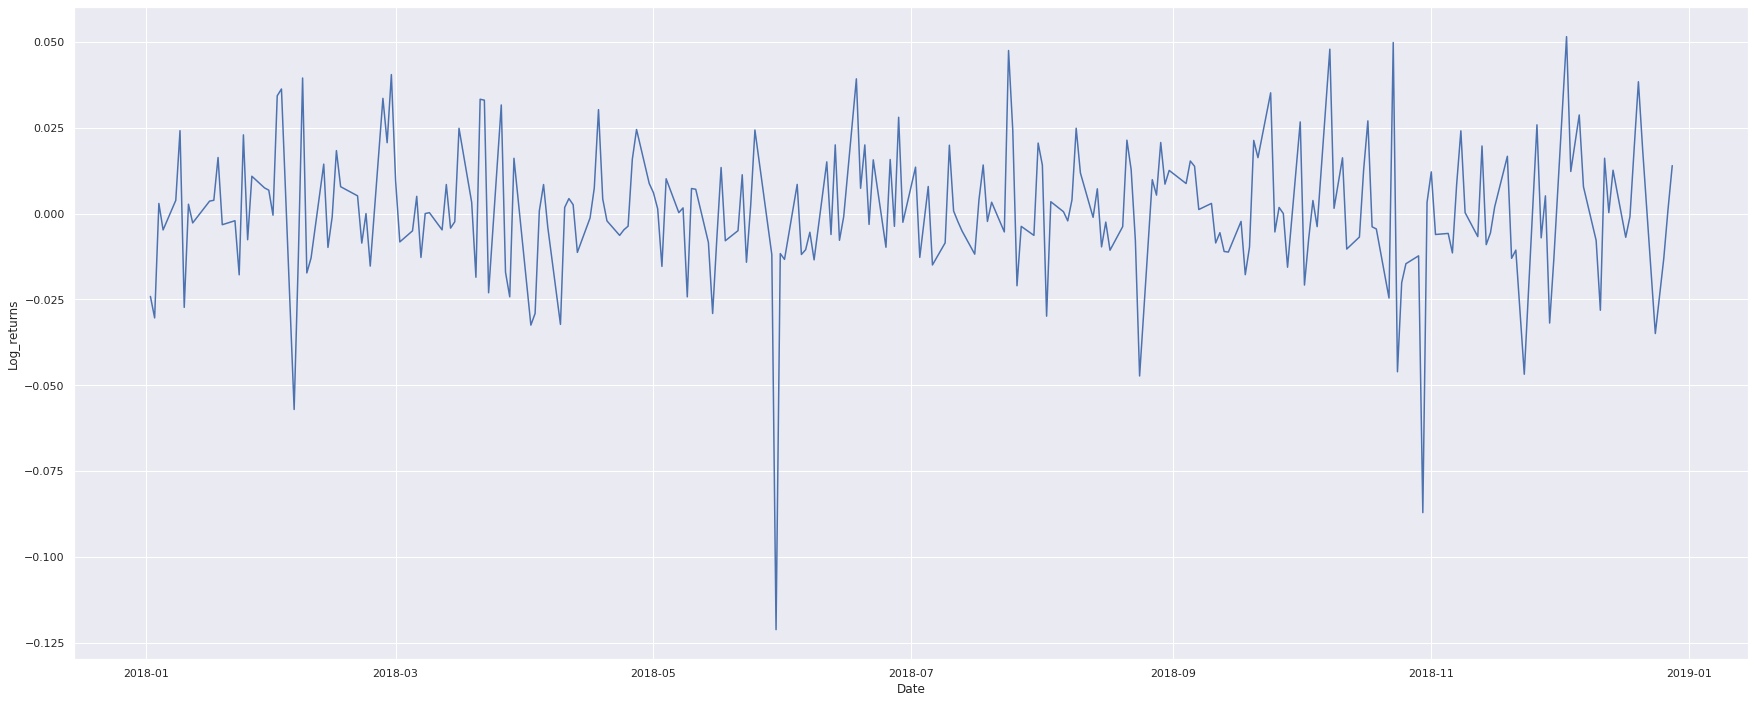

In [ ]:
esns.set(rc={'figure.figsize':(30,12)})
sns.lineplot(data=stock_data_augmented, x="Date", y="Log_returns")

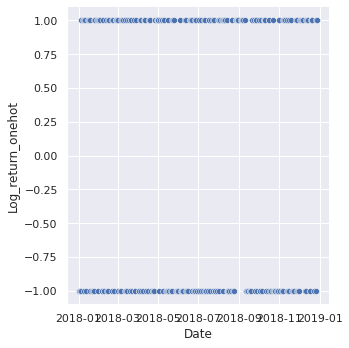

In [ ]:
sns.set(rc={'figure.figsize':(80,12)})

sns.relplot(data=stock_data_augmented, x="Date", y="Log_return_onehot")

In [ ]:
###Auto & Related
# GM: general motors
#CAT: Heavy equipment manufacturer Caterpillar
###technology
#Nvidia is a semiconductor company focused on visual computing
#Skyworks Solutions is a trailblazer in the semiconductor and wireless chip space
###Agriculture
#Agricultural commodity supplier and trader Bunge 
#Farm equipment maker Deere
###Transport
#Rail transportation stock CSX Corp
#Storied American company Harley-Davidson 
stocks=['GM','CAT','NVDA','SWKS','BG','DE','CSX','HOG']

In [ ]:
from google.colab import files


In [ ]:
for stock in stocks:
  stock_ticker= yf.Ticker(stock)
  stock_data=get_asset_data(stock,start="2017-12-30", end="2020-12-30", interval="1d")
  stock_data_augmented = compute_return(stock_data)
  stock_data_augmented.to_csv("{0}_data.csv".format(stock))
  files.download('{0}_data.csv'.format(stock))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>